# Pipeline selection

In this tutorial, we will learn how to choose a suitable pipeline for 
a PPM task. We will compare two approaches for preparing data before 
training Gradient Boosting and Random Forest regressors. The first 
approach uses more detailed steps, including timestamp features, 
one-hot encoding, and resource pool extraction. The second approach is 
simpler and relies only on one-hot encoding. We will train each type 
of model with each approach to see how they perform.

Let us first import the necessary libraries and set the random seed  for reproducibility.

In [121]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from skpm.sequence_encoding import Aggregation
from skpm.config import EventLogConfig as elc
from skpm.event_logs import BPI20PrepaidTravelCosts, split
from skpm.feature_extraction.targets import remaining_time
from skpm.feature_extraction import TimestampExtractor, ResourcePoolExtractor

# Set random state for reproducible results
RANDOM_STATE = 44
np.random.seed(RANDOM_STATE)

Below we load one of the BPI20 event logs, select relevant columns 
for this example, extract the remaining time to use as the target, 
and split the data into train and test sets.1

In [ ]:
from skpm.event_logs.bpi import BPI17

log = BPI17()

# Select basic columns
df = log.dataframe[[elc.case_id, elc.activity, elc.resource, elc.timestamp]].copy()
df[elc.timestamp] = pd.to_datetime(df[elc.timestamp], utc=True)

# Compute remaining time in seconds
df["remaining_time"] = remaining_time(df, time_unit="h")

# Split into train/test sets using provided split method
train, test = split.unbiased(df, **log.unbiased_split_params)

# Separate features and targets for train and test
X_train = train.drop(columns=["remaining_time"])
y_train = train[["remaining_time"]]
X_test = test.drop(columns=["remaining_time"])
y_test = test[["remaining_time"]]

sc = StandardScaler()
y_train = sc.fit_transform(y_train).values.ravel()
y_test = sc.transform(y_test).values.ravel()

## Preprocessing pipelines

We will define two different pipelines for preprocessing the data before
training the models.

- A **simple** data preparation pipeline: let's just one-hot encode activity labels and discard other features
- A more **complex** one: let's engineer some features from the resources and timestamps. 

In [156]:
EVENT_FEATURES = [
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "secs_within_day",
    "week_of_year",
]

data_prep_advanced = Pipeline([
    ("preprocessing", ColumnTransformer(
        transformers=[
            ("timestamp_features", TimestampExtractor(case_features="accumulated_time", event_features=EVENT_FEATURES), [elc.timestamp, elc.case_id]),
            ("activity_encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), [elc.activity]),
            ("resource_pool", ResourcePoolExtractor(threshold=0.5), [elc.case_id, elc.activity, elc.resource]),
            ("case_id_pass", "passthrough", [elc.case_id]),
        ])),
    ("encode_agg", Aggregation(method="norm", prefix_len=3)),
    ("scaling", StandardScaler()),
])

data_prep_simple = Pipeline([
    ("preprocessing", ColumnTransformer(
        transformers=[
            ("activity_encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), [elc.activity]),
            ("case_id_pass", "passthrough", [elc.case_id]),
    ])),
    ("encode_agg", Aggregation(method="norm", prefix_len=3)),
    ("scaling", StandardScaler()),
])

## Training models

We will train two Gradient Boosting and two Random Forest models
using the advanced and simple preprocessing pipelines. We will then
evaluate the models using the root mean squared error (RMSE) metric.

In [157]:
# Gradient Boosting pipelines
gb_pipe_advanced = Pipeline([
    ("preprocessing", data_prep_advanced),
    ("regressor", GradientBoostingRegressor(learning_rate=0.2, random_state=RANDOM_STATE))
])

gb_pipe_simple = Pipeline([
    ("preprocessing", data_prep_simple),
    ("regressor", GradientBoostingRegressor(learning_rate=0.2, random_state=RANDOM_STATE))
])

# Random Forest pipelines
rf_pipe_advanced = Pipeline([
    ("preprocessing", data_prep_advanced),
    ("regressor", RandomForestRegressor(max_depth=8, random_state=RANDOM_STATE))
])

rf_pipe_simple = Pipeline([
    ("preprocessing", data_prep_simple),
    ("regressor", RandomForestRegressor(max_depth=8, random_state=RANDOM_STATE))
])

# Xgb pipelines
xgb_pipe_advanced = Pipeline([
    ("preprocessing", data_prep_advanced),
    ("regressor", XGBRegressor(learning_rate=0.2, random_state=RANDOM_STATE))
])

xgb_pipe_simple = Pipeline([
    ("preprocessing", data_prep_simple),
    ("regressor", XGBRegressor(learning_rate=0.2, random_state=RANDOM_STATE))
])

Fitting everyone:

In [158]:
gb_pipe_advanced.fit(X_train, y_train)
gb_pipe_simple.fit(X_train, y_train)
rf_pipe_advanced.fit(X_train, y_train)
rf_pipe_simple.fit(X_train, y_train)
xgb_pipe_advanced.fit(X_train, y_train)
xgb_pipe_simple.fit(X_train, y_train);

## Results

In [ ]:
scores = pd.DataFrame({
    "model": ["GB1_complex", "GB2_simple", "RF_complex", "RF2_simple", "XGB_complex", "XGB_simple"],
    "score": [
        root_mean_squared_error(y_test, gb_pipe_advanced.predict(X_test)),
        root_mean_squared_error(y_test, gb_pipe_simple.predict(X_test)),
        root_mean_squared_error(y_test, rf_pipe_advanced.predict(X_test)),
        root_mean_squared_error(y_test, rf_pipe_simple.predict(X_test)),
        root_mean_squared_error(y_test, xgb_pipe_advanced.predict(X_test)),
        root_mean_squared_error(y_test, xgb_pipe_simple.predict(X_test)),
    ]
})

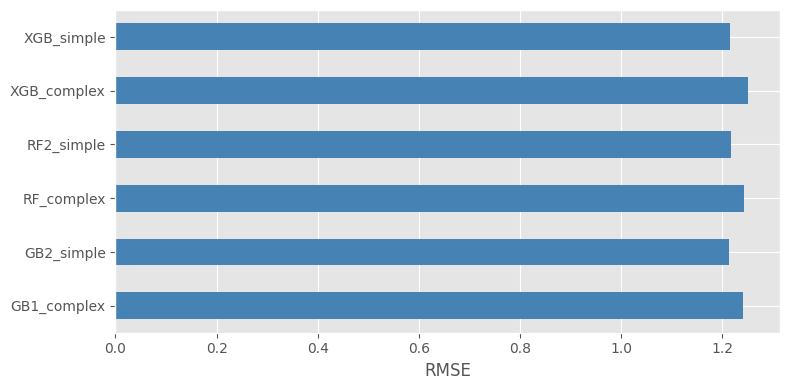

In [162]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

scores.plot(
    kind="barh", 
    x="model", 
    y="score", 
    color="steelblue", 
    legend=False,
    figsize=(8, 4)
)
plt.ylabel("")
plt.xlabel("RMSE")
# plt.xscale("log")
plt.tight_layout()